# 1. First Steps

## 1.1 Load Data

We use pandas to load data from `.csv` files into a Pandas Dataframe. We will utilize this dataframe to look at our data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import os
import gc

# Get data from csv as pandas dataframe
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

IN_DEVELOPMENT = False

if IN_DEVELOPMENT:
    # reduce the number of samples for quicker dev
    train_df = train_df[:500000]
    test_df = test_df[:150000]

# split train data into validation and train data
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1175509, 3)
(130613, 3)
(375806, 2)


## 1.2 Analyze our Data

Ideally, I want to look at our data and see if our training data is somehow skewed in a certain way. I seek answers to the following question(s):

1. What is the proportion of insincere questions to sincere questions in our training data?

### 1.2.1 What is the proportion of insincere questions to sincere questions in our training data?

In [2]:
print("Mean of target:")
print("Closer to 0 -> More Sincere Questions")
print("Closer to 1 -> More Insincere Questions")
train_df.loc[:, "target"].mean()

Mean of target:
Closer to 0 -> More Sincere Questions
Closer to 1 -> More Insincere Questions


0.061832789030113765

We see from the results that there are significantly more sincere questions (mean = ~0.06). This can impact our model because a model that says that all questions are sincere would do pretty well here. (~93% correct)

## 1.3 Create Baseline Models For Comparison

1. 50-50 Chance Random guessing
2. Naively implemented Sentiment Analysis (Not Neural net-based)
3. Model without pretrained word embedding layer

### 1.3.1 Random Guess Model

In [3]:
from random import randint

def guess_model(data):
    num_correct, num_samples = 0, 0
    for sample in data:
        prediction = randint(0, 1)
        if prediction == sample:
            num_correct += 1
        num_samples += 1
    return num_correct / num_samples

train_data = train_df.loc[:, 'target']
print(guess_model(train_data))

0.5000293489883957


As one would expect, this model is roughly 50% accurate in binary classification. Let's see if we can do better with our other baseline models

### 1.3.2 Naively Implemented Sentiment Analysis

We will create a model that performs regular sentiment analysis (negative / positive), and hope that positive texts will correlate well to sincere texts, and likewise for negative texts to insincere texts.

The way this implementation works is that it takes the polarity of each text as a whole if it's more positive, then this model's prediction will be that it is sincere, if not, then the model's prediction will be that it is not sincere.

A caveat with this approach is that this model is unable to understand the relationship that words can have with each other. Meaning, that at the end of the day, we are looking at a word-by-word analysis of this text, and not considering the relationship of different words can have with each other that can alter the meaning of sentences.

```
ie: hang a man (negative. This basically means to kill a man)
ie: hang man (neutral. This is a game, so not really negative.)
```

The previous two sentences share 2 words with each other, and have drastically different meanings and there are many other similar examples, so I expect that the accuracy of this model to be either around the same as the 50-50 model, or lower.

In [4]:
from textblob import TextBlob

def sentiment_analysis_model(data):
    num_correct, num_samples = 0, 0
    for (text, label) in data:
        sentiment = TextBlob(text).sentiment
        # polarity is -1 to 1
        polarity = (sentiment.polarity + 1) / 2
        # we want to flip here: low polarity -> negative connotation, so we need to round and then flip values
        prediction = 0 if round(polarity) == 1 else 1
        if prediction == label:
            num_correct += 1
        num_samples += 1
    return num_correct / num_samples
        
# the textblob library takes quite a bit of time, so we limit our samples to 10000
sent_analysis_data = train_df.loc[:, ['question_text', 'target']].values[:10000]

print(sentiment_analysis_model(sent_analysis_data))

0.3695


This model's accuracy is quite low (~36%), which I suppose has to do with a low correlation between sentiment (positive/negative) and sincerity in texts as well as the aforementioned caveat in the previous markdown cell.

### 1.3.3 Deep Learning Model without pretrained embedding layer

This model is below in section 4

In [5]:
# Cleanup any unused vars
del sent_analysis_data, train_data
# manually use garbage collector to clean up any unused variables
gc.collect()

1450

# 2. Preprocess Data

In [6]:
from unicodedata import normalize
import re
import string

# Preprocess Sentences
def clean_data(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    max_length = 0
    for line in lines:
        # normalize unicode characters
        line = normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8')
        # tokenize on white space
        line = line.split()
        # convert to lowercase
        line = [word.lower() for word in line]
        # remove punctuation from each token
        line = [word.translate(table) for word in line]
        # remove non-printable chars form each token
        line = [re_print.sub('', w) for w in line]
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
        length = len(line)
        if length > max_length:
            max_length = length
        # store as string
        line = ' '.join(line)
        cleaned.append(line)
    return np.array(cleaned), max_length

In [7]:
# fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

train_X, max_len_trainX = clean_data(train_X)
val_X, max_len_valX = clean_data(val_X)
test_X, max_len_testX = clean_data(test_X)

for i in range(10):
    print(train_X[i])

what have been the best exhibits at the museo del prado in madrid
how can i rotate batch image files
which is the best cable operator in thane west area
how do i expand factor and simplify in algebra
do you judge people often
how do i get above in icse in all subjects in
how do i use the grid method
can you hang a poster diagonally if you have a good reason for it
do many bulgarians consider macedonia part of bulgaria
did you have any superb business india on your mind


# 3. Text to Sequence

## 3.1 Define tunable parameters for preprocessing texts

In [8]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

## 3.2 Preprocess Texts

We use the keras `preprocessing` module to tokenize (`preprocessing.text.Tokenizer`) our text and then pad our resulting sequences with 0's at the end

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# word-level tokenizing
tokenizer = Tokenizer(num_words=max_features)

# train tokenizer
tokenizer.fit_on_texts(list(train_X))
print("Finished fitting tokenizer! Turning texts to sequences...")

# tokenized texts -> sequences
train_seq_X = tokenizer.texts_to_sequences(train_X)
val_seq_X = tokenizer.texts_to_sequences(val_X)
test_seq_X = tokenizer.texts_to_sequences(test_X)
print("Finished turning texts to sequences! Padding sequences...")

# pad sequences
train_seq_X = pad_sequences(train_seq_X, maxlen=maxlen, padding='post')
val_seq_X = pad_sequences(val_seq_X, maxlen=maxlen, padding='post')
test_seq_X = pad_sequences(test_seq_X, maxlen=maxlen, padding='post')
print("Finished padding sequences! Getting target labels...")

# get target labels
train_Y = train_df["target"].values
val_Y = val_df["target"].values
print("Finished getting target labels!\n")

print("shape of train_seq_X:", train_seq_X.shape)
print("shape of val_seq_X:", val_seq_X.shape)
print("shape of test_seq_X:", test_seq_X.shape)

print("shape of train_Y:", train_Y.shape)
print("shape of val_Y:", val_Y.shape)

Using TensorFlow backend.


Finished fitting tokenizer! Turning texts to sequences...
Finished turning texts to sequences! Padding sequences...
Finished padding sequences! Getting target labels...
Finished getting target labels!

shape of train_seq_X: (1175509, 100)
shape of val_seq_X: (130613, 100)
shape of test_seq_X: (375806, 100)
shape of train_Y: (1175509,)
shape of val_Y: (130613,)


In [10]:
try:
    del train_df, val_df, train_X, val_X, test_X
    import gc; gc.collect()
    time.sleep(10)
    print("cleaned dataframes and texts!")
except NameError:
    print("dataframes and texts already deleted!")

dataframes and texts already deleted!


# 4. Embedding, Creating and Training Model

We create a matrix of word associations in relationship to our texts.

## 4.1 Creating Embedding Dictionaries from Supplied Files

For this part: I referred to intuitions made in this [kernel](https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings)

In [11]:
# Embedding
PARAGRAM_EMBED = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
WIKI_NEWS_EMBED = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
GLOVE_EMBED = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'

def get_embeddings(file):
    """return as a numpy array the coefficients of word embeddings from a file"""
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if "glove" in file:
        return dict(get_coefs(*o.split(" ")) for o in open(file))
    elif "wiki" in file:
        return dict(get_coefs(*o.split(" ")) for o in open(file) if len(o) > 100)
    elif "paragram" in file:
        return dict(get_coefs(*o.split(" ")) for o in open(file, encoding="utf8", errors='ignore') if len(o) > 100)
    else:
        print("invalid embeddings file")

## 4.2 Create model

Here, we use the embedding that we created in the cell before to create a model with an embedding layer whose weights we will use the embedding from the supplied files

In [12]:
from keras.layers import Input, Embedding, Dense, Input, LSTM, Embedding
from keras.layers import Dropout, Activation, CuDNNGRU, Conv1D, Bidirectional, GlobalMaxPool1D
from keras.models import Model

def create_model(embedding_matrix, embed_size, maxlen=maxlen, max_features=max_features):
    """Create model for binary classification of texts as insincere vs. not insincere"""
    inp = Input(shape=(maxlen,))
    if embedding_matrix is not None:
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    else:
        x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    return model

def setup_model(embeddings_index, tokenizer, embed_size):
    """Extract necessary components of embedding dictionaries and create a model"""
    if not embeddings_index:
        return create_model(None, embed_size)
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            
    # create model        
    return create_model(embedding_matrix, embed_size)

## 4.3 Compile and Train our Model

We get our word embeddings, then create, compile and train models. After each test, we clean out our memory, so that we can train another model without incurring massive memory usage.

### 4.3.1 Baseline Model

In [13]:
# No pretrained word embeddings here.

print("baseline model:")
baseline_model = setup_model(None, tokenizer, embed_size)
baseline_model.summary()

baseline model:
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropo

In [14]:
# compile model
baseline_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Fit Model
history = baseline_model.fit(train_seq_X, train_Y, batch_size=512, epochs=2, validation_data=(val_seq_X, val_Y))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 91s 78us/step - loss: 0.1214 - acc: 0.9537 - val_loss: 0.1077 - val_acc: 0.9571
Epoch 2/2
1175509/1175509 [==============================] - 88s 74us/step - loss: 0.0982 - acc: 0.9606 - val_loss: 0.1072 - val_acc: 0.9572


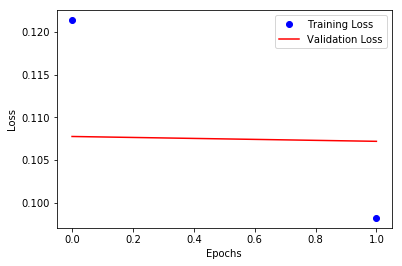

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Make a Prediction on the validation data set
pred_base_val_y = baseline_model.predict([val_seq_X], batch_size=1024, verbose=1)

130613/130613 [==============================] - 2s 16us/step


In [18]:
import time

# do some cleanup
try:
    del baseline_model
    import gc; gc.collect()
    time.sleep(10)
except NameError:
    print("baseline_model already deleted!")

### 4.3.2 Paragram Word Embeddings Model

We use the weights obtained from the paragram word embeddings for our embedding layer

In [19]:
# Embedding indices of embedding file
print("Loading paragram embeddings...")
try:
    print("checking if we already created paragram embeddings dict...")
    paragram_embed_index
    print("we already created it")
except NameError:
    print("we did not... creating paragram embeddings dictionary")
    paragram_embed_index = get_embeddings(PARAGRAM_EMBED)

# create model with embedding layer based on pretrained weights from paragram word embedding
print("paragram model:")
paragram_model = setup_model(paragram_embed_index, tokenizer, embed_size)
paragram_model.summary()

Loading paragram embeddings...
checking if we already created paragram embeddings dict...
we did not... creating paragram embeddings dictionary
paragram model:


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

In [20]:
# compile
paragram_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Fit Model
history = paragram_model.fit(train_seq_X, train_Y, batch_size=512, epochs=2, validation_data=(val_seq_X, val_Y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 90s 77us/step - loss: 0.1171 - acc: 0.9538 - val_loss: 0.1032 - val_acc: 0.9587
Epoch 2/2
1175509/1175509 [==============================] - 87s 74us/step - loss: 0.0960 - acc: 0.9620 - val_loss: 0.1019 - val_acc: 0.9592


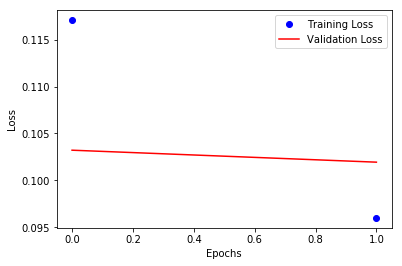

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Make a Prediction on the validation data set
pred_paragram_val_y = paragram_model.predict([val_seq_X], batch_size=1024, verbose=1)
# Make a Prediction on the test data set
pred_paragram_test_y = paragram_model.predict([test_seq_X], batch_size=1024, verbose=1)

375806/375806 [==============================] - 6s 15us/step


In [24]:
try:
    del paragram_embed_index, paragram_model
    gc.collect()
    time.sleep(10)
    print("cleaned baseline_model vars!")
except NameError:
    print("baseline_model already deleted!")

cleaned baseline_model vars!


### 4.3.3 Glove Word Embeddings

We use the weights obtained from the glove word embeddings for our embedding layer

In [25]:
# Embedding indices of embedding file
print("Loading glove embeddings...")
try:
    print("checking if we already created glove embeddings dict...")
    glove_embed_index
    print("we already created it")
except NameError:
    print("we did not... creating glove embeddings dictionary")
    glove_embed_index = get_embeddings(GLOVE_EMBED)

# create model with embedding layer based on pretrained weights from paragram word embedding
print("glove model:")
glove_model = setup_model(glove_embed_index, tokenizer, embed_size)
glove_model.summary()

Loading glove embeddings...
checking if we already created glove embeddings dict...
we did not... creating glove embeddings dictionary
glove model:


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total para

In [26]:
# compile
glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# Fit Model
history = glove_model.fit(train_seq_X, train_Y, batch_size=512, epochs=2, validation_data=(val_seq_X, val_Y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 89s 76us/step - loss: 0.1120 - acc: 0.9564 - val_loss: 0.1022 - val_acc: 0.9586
Epoch 2/2
1175509/1175509 [==============================] - 86s 74us/step - loss: 0.0929 - acc: 0.9629 - val_loss: 0.1007 - val_acc: 0.9596


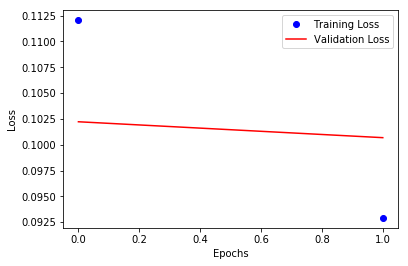

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Make a Prediction on the validation data set
pred_glove_val_y = glove_model.predict([val_seq_X], batch_size=1024, verbose=1)
# Make a Prediction on the test data set
pred_glove_test_y = glove_model.predict([test_seq_X], batch_size=1024, verbose=1)

375806/375806 [==============================] - 6s 15us/step


In [30]:
try:
    del glove_embed_index, glove_model
    import gc; gc.collect()
    time.sleep(10)
    print("cleaned baseline_model vars!")
except NameError:
    print("baseline_model already deleted!")

cleaned baseline_model vars!


### 4.4.4 Wiki News Word Embedding Model

We use the weights obtained from the glove word embeddings for our embedding layer

In [31]:
# Embedding indices of embedding file
print("Loading wiki embeddings...")
try:
    print("checking if we already created wiki embeddings dict...")
    wiki_embed_index
    print("we already created it")
except NameError:
    print("we did not... creating wiki embeddings dictionary")
    wiki_embed_index = get_embeddings(WIKI_NEWS_EMBED)

# create model with embedding layer based on pretrained weights from paragram word embedding
print("wikinews model:")
wikinews_model = setup_model(wiki_embed_index, tokenizer, embed_size)
wikinews_model.summary()

Loading wiki embeddings...
checking if we already created wiki embeddings dict...
we did not... creating wiki embeddings dictionary
wikinews model:


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total para

In [32]:
# compile
wikinews_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# Fit Model
history = wikinews_model.fit(train_seq_X, train_Y, batch_size=512, epochs=2, validation_data=(val_seq_X, val_Y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 89s 76us/step - loss: 0.1169 - acc: 0.9554 - val_loss: 0.1042 - val_acc: 0.9586
Epoch 2/2
1175509/1175509 [==============================] - 87s 74us/step - loss: 0.0942 - acc: 0.9628 - val_loss: 0.1035 - val_acc: 0.9591


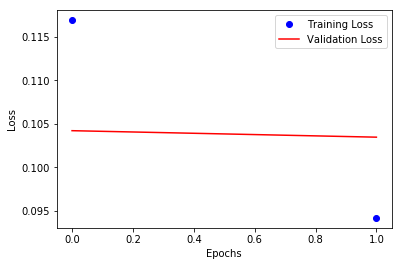

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Make a Prediction on the validation data set
pred_wiki_val_y = wikinews_model.predict([val_seq_X], batch_size=1024, verbose=1)
# Make a Prediction on the test data set
pred_wiki_test_y = wikinews_model.predict([test_seq_X], batch_size=1024, verbose=1)

375806/375806 [==============================] - 6s 15us/step


In [36]:
try:
    del wiki_embed_index, wikinews_model
    import gc; gc.collect()
    time.sleep(10)
    print("cleaned wikinews_model vars!")
except NameError:
    print("wikinews_model already deleted!")

cleaned wikinews_model vars!


## 4.4 Analyze the Results

Here, we use the f1-score metric to compare the baseline model with using 1 of each provided word embedding, and see which is the best

In [37]:
from sklearn.metrics import f1_score


preds = [pred_base_val_y, pred_paragram_val_y, pred_glove_val_y, pred_wiki_val_y]
pred_labels = ['baseline model:', 'paragram model:', 'glove model:', 'wiki news model']
model_predictions = zip(preds, pred_labels)

# Analyze results
# The F1 score can be interpreted as a weighted average of the precision and recall
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
best_scores = []
for (pred, label) in model_predictions:
    best_thresh, best_f1_score = 0, 0
#     print(label)
    for thresh in np.arange(0.1, 0.501, 0.01):
        curr_thresh = np.round(thresh, 2)
        curr_f1 = f1_score(val_Y,(pred>thresh).astype(int))
        if curr_f1 > best_f1_score:
            best_thresh = curr_thresh
            best_f1_score = curr_f1
#         print("F1 score at threshold {0} is {1}".format(curr_thresh, curr_f1))
    best_scores.append([best_thresh, best_f1_score])
#     print('\n')
    
print("The best scores are:\n")
for ((thresh, f1), label) in zip(best_scores, pred_labels):
    print("The best score for {0}".format(label))
    print("Threshold:", thresh)
    print("F1 score:", f1)
    print('\n')

The best scores are:

The best score for baseline model:
Threshold: 0.32
F1 score: 0.6548850735417483


The best score for paragram model:
Threshold: 0.34
F1 score: 0.6746744499326448


The best score for glove model:
Threshold: 0.35
F1 score: 0.6774870892684866


The best score for wiki news model
Threshold: 0.31
F1 score: 0.6737046336452864




Above, we saw that the best word embedding to use was the glove word embeddings with a f1 score of ~0.66-7. Below, we check and see if we can improve on this using ensembling methods.

In [38]:
# take some of the results from each embedding model.
pred_ensemble_val_y = 0.33 * pred_paragram_val_y + 0.33 * pred_glove_val_y + 0.34 * pred_wiki_val_y
best_thresh, best_f1_score = 0, 0
for thresh in np.arange(0.1, 0.501, 0.01):
    curr_thresh = np.round(thresh, 2)
    curr_f1 = f1_score(val_Y,(pred_ensemble_val_y>thresh).astype(int))    
    if curr_f1 > best_f1_score:
        best_thresh = curr_thresh
        best_f1_score = curr_f1
 
print("The best score for ensemble")
print("Threshold:", best_thresh)
print("F1 score:", best_f1_score)
print('\n')

The best score for ensemble
Threshold: 0.35
F1 score: 0.6848904267589389




Here, we used a mix of the results of all three word embeddings and found that the result is actually just a little better (~0.01 improvement) than just using one. Perhaps this is due to each of the models capturing something a little different from each other, and therefore, using ensembling here works although, it may not be worth the extra time in training the other two models because the improvement from using the glove model to ensembling methods is almost negligible.

# 5 Create Test Submission

Up to this point, we've preprocessed text, turned it into a sequence, padded it, loaded embeddings, created a model, trained it, and then tested/tuned it for optimal performance.

Now, all I have to do is to use this model that I've trained and create a submission for this competition.

I already used the last three models to predict the values of the test set when I created the predictions on the validation set. Now, we just need to use them.

As determined by the last test, we will use our best method, the ensembling model predictions.

In [39]:
pred_ensemble_test_y = 0.33 * pred_paragram_test_y + 0.33 * pred_glove_test_y + 0.34 * pred_wiki_test_y

# round values to 0 / 1
y_te = (np.array(pred_ensemble_test_y) > 0.5).astype(np.int).reshape(len(pred_ensemble_test_y),)

# create dataframe of ["qid", "prediction"]
submit_df = pd.DataFrame({"qid": test_df["qid"], "prediction": y_te})

# create .csv file
submit_df.to_csv("submission.csv", index=False)